# Bayesian linear regressions

Objectives:
- Use MCMC sampling to perform a Bayesian version of standard linear regression.
- Repeat the same trying to fit a piecewise linear function to some data.

In [1]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import arviz as az

az.style.use("arviz-darkgrid")
tfd = tfp.distributions

## Linear regression

We'll generate synthetic data for the fit. The data is normally distributed around a straight line. To make things more interesting we'll write a single joint distribution for everything: the parameters of the distribution of the data (slope, intercept and variance of the Normal distribution) and the data itself.

### Generate synthetic data

2022-04-15 09:46:53.254283: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


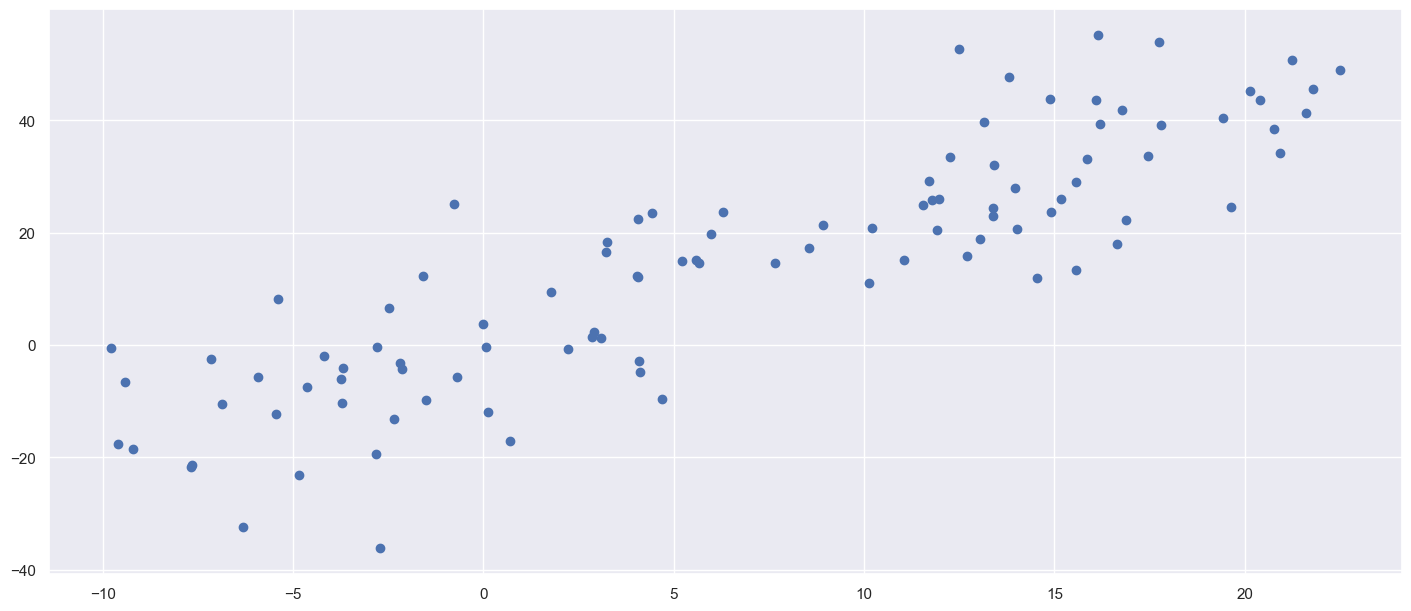

In [2]:
n_points = 100

joint_distr_synthetic = tfd.JointDistributionSequential([
    tfd.Uniform(
        low=-10.5 * tf.ones(shape=n_points), high=23. * tf.ones(shape=n_points)
    ),  # x coordinates of the datapoints.
    tfd.Normal(loc=2.5, scale=3.),  # m
    tfd.Uniform(low=-5., high=12.),  # q
    tfd.TransformedDistribution(
        tfd.HalfNormal(scale=.5),
        tfp.bijectors.Shift(shift=10.)),  # sigma
    lambda sigma, q, m, x_data: tfd.Independent(
        tfd.Normal(loc=x_data * m + q, scale=sigma),
        reinterpreted_batch_ndims=1)
])

# Sample the joint distribution.
distr, samples = joint_distr_synthetic.sample_distributions()

x_data, m_sampled, q_sampled, sigma_sampled, y_data = samples

# Plot the samples.
fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=x_data,
    y=y_data)

### Bayesian linear regression

We start by writing our Bayesian model, i.e. a distribution that descirbes how we think the data was generated, including the priors from the parametres (and pretending we never saw the distribution that generated the data to begin with!). This is our modelling hypothesis.

In [3]:
def trace_stuff(states, previous_kernel_results):
    """
    """
    # I couldn't find a way not to make the counter global.
    step = next(counter)
    
    if (step % 100) == 0:
        print(f"Step {step}, state: {states}")
    
    return previous_kernel_results

In [4]:
joint_prob = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=20.),  # Prior for m.
    tfd.Normal(loc=0, scale=30.),  # Prior for q.
    tfd.Uniform(low=0., high=50.),  # Prior for sigma.
    # Note: the Independent distribution here is needed so a single sample
    #       of this distribution corresponds to the whole dataset, which means
    #       that given values for m, q, sigma and x and y coordinated of the
    #       datapoints, a call to the log_prob method returns a scalar.
    # Note: the batch size is kept nontrivial, which is the way we deal with
    #       sampling from multiple chains in parallel.
    lambda sigma, q, m: tfd.Independent(
        tfd.Normal(
            loc=tf.transpose(tf.expand_dims(x_data, 1)) * tf.expand_dims(m, -1) + tf.expand_dims(q, -1),
            scale=tf.expand_dims(sigma, -1)
        ),
        reinterpreted_batch_ndims=1
    )
])

joint_log_prob_closure = (
    lambda m, q, sigma: joint_prob.log_prob(m, q, sigma, y_data))

In [5]:
# Test that the closure of the joint log prob correclty evaluates potential
# values for m, q and sigma.
n_chains = 4

test_state = [
    1. * tf.ones(shape=n_chains),
    1. * tf.ones(shape=n_chains),
    1. * tf.ones(shape=n_chains),
]

joint_log_prob_closure(*test_state)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-12024.948, -12024.948, -12024.948, -12024.948], dtype=float32)>

In [6]:
# Set the chain's start state using a the frequentist statistics estimators.
lr = LinearRegression(fit_intercept=True)
lr.fit(x_data.numpy().reshape(-1, 1), y_data.numpy())

max_lik_est_m = tf.constant(lr.coef_[0])
max_lik_est_q = tf.constant(lr.intercept_)

residuals = (
    y_data
    - (x_data * max_lik_est_m + max_lik_est_q)
)

max_likest_sigma = tf.sqrt(tf.reduce_sum(residuals * residuals) / (n_points - 2))


initial_chain_state = [    
    max_lik_est_m * tf.ones(shape=n_chains),
    max_lik_est_q * tf.ones(shape=n_chains),
    max_likest_sigma * tf.ones(shape=n_chains)
]

initial_chain_state

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.0073972, 2.0073972, 2.0073972, 2.0073972], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.85251904, 0.85251904, 0.85251904, 0.85251904], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([10.561818, 10.561818, 10.561818, 10.561818], dtype=float32)>]

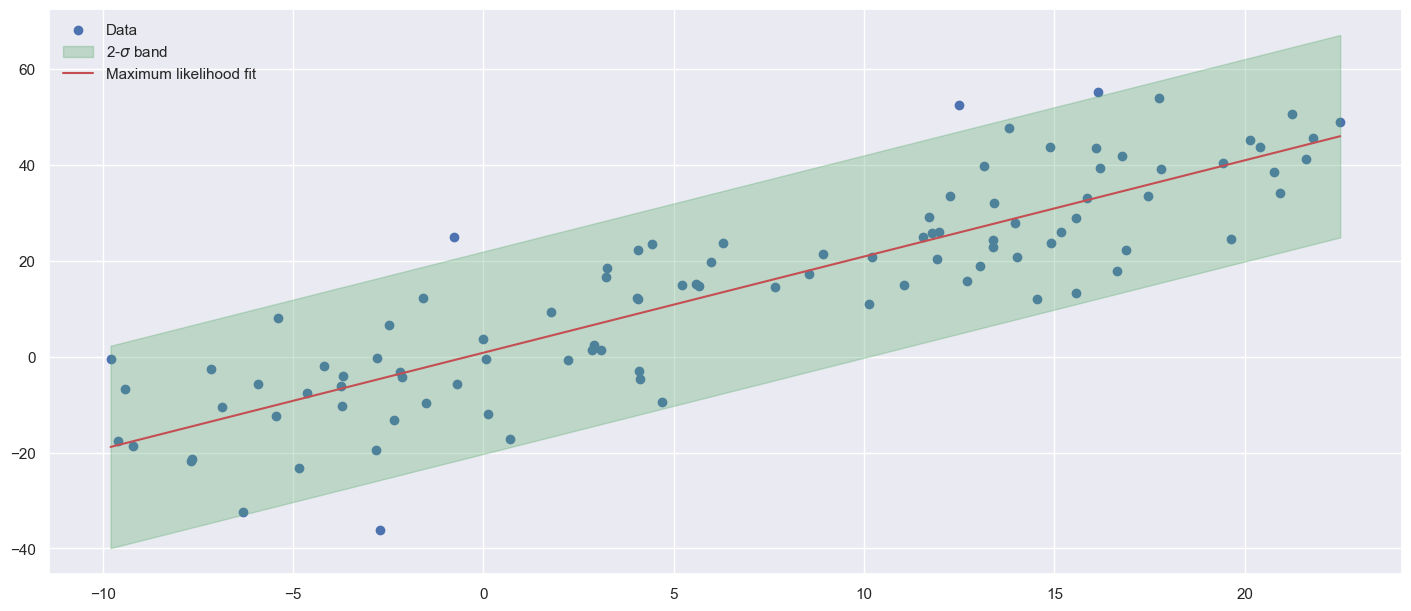

In [7]:
# Plot the frequentist linear regression.
fig = plt.figure(figsize=(14, 6))

sns.set_theme()

data_max_lik_fit = tf.sort(tf.transpose(tf.stack([
    x_data, x_data * max_lik_est_m + max_lik_est_q])), axis=0)

data_max_lik_fit

plt.scatter(
    x=x_data,
    y=y_data,
    color='b',
    label='Data')

plt.fill_between(
    x=data_max_lik_fit[:, 0].numpy(),
    y2=(data_max_lik_fit[:, 1] - 2. * max_likest_sigma).numpy(),
    y1=(data_max_lik_fit[:, 1] + 2. * max_likest_sigma).numpy(),
    alpha=0.3,
    color='g',
    label='2-$\sigma$ band'
)

plt.plot(
    data_max_lik_fit[:, 0].numpy(),
    data_max_lik_fit[:, 1].numpy(),
    color='r',
    label='Maximum likelihood fit')

plt.legend(loc='upper left')

In [8]:
number_of_steps = 5000
burnin = 1000
leapfrog_steps=3

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),  # Maps R to R (m).
    tfp.bijectors.Identity(),  # Maps R to R (q).
    tfp.bijectors.Exp(),  # Maps R to (0, +oo) (sigma).
]

# Initialize the step_size. (It will be automatically adapted.)
step_size = tf.Variable(0.5, dtype=tf.float32)

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=joint_log_prob_closure,
        num_leapfrog_steps=3,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
print('Sampling started')

counter = itertools.count(1)

[
    trace_m,
    trace_q,
    trace_sigma
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps + burnin,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc,
    trace_fn=trace_stuff
)

print('Sampling finished')

trace_m_burned = trace_m[burnin:, :]
trace_q_burned = trace_q[burnin:, :]
trace_sigma_burned = trace_sigma[burnin:, :]

posterior_means = {
    'm': tf.reduce_mean(trace_m_burned, axis=0),
    'q': tf.reduce_mean(trace_q_burned, axis=0),
    'sigma': tf.reduce_mean(trace_sigma_burned, axis=0)}

inference_data = az.convert_to_inference_data({
    'm': tf.transpose(trace_m_burned),
    'q': tf.transpose(trace_q_burned),
    'sigma': tf.transpose(trace_sigma_burned)
})

Instructions for updating:
Use tfp.mcmc.SimpleStepSizeAdaptation instead.
Sampling started


/Users/emanuele_moscato/anaconda3/envs/bayesian-explorations/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/internal/util.py:363: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  warnings.warn(


Step 100, state: [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.0185463, 2.115457 , 2.0065181, 2.0302415], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-2.482522 ,  1.3657355,  0.8996543,  0.7219995], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([11.36109 , 11.094562,  9.123825,  9.980155], dtype=float32)>]
Step 200, state: [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.0729036, 1.8895926, 2.0132477, 2.1255093], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 1.3198203 ,  1.4142263 , -0.78831697,  0.9035442 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([11.35314 , 10.242621, 10.467929, 11.65784 ], dtype=float32)>]
Step 300, state: [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.9946108, 1.9436522, 1.8966258, 2.169095 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.44990563,  3.1944127 , -0.19368924,  0.303274  ], dtype=float32)>, <tf.Tensor: sh

In [9]:
kernel_results.inner_results.is_accepted.numpy().mean()

0.7349583333333334

In [10]:
posterior_means

{'m': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.0026033, 2.0089068, 2.0108645, 2.001661 ], dtype=float32)>,
 'q': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.91608846, 0.8087699 , 0.8120544 , 0.96352655], dtype=float32)>,
 'sigma': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([10.72451 , 10.694536, 10.685744, 10.720978], dtype=float32)>}

In [11]:
m_sampled, q_sampled, sigma_sampled

(<tf.Tensor: shape=(), dtype=float32, numpy=1.932524>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.84760475>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.225004>)

In [12]:
inference_data

Inference data with groups:
	> posterior

In [13]:
az.summary(inference_data)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m       2.006  0.118   1.777    2.222      0.004    0.003     836.0    1758.0   
q       0.875  1.278  -1.478    3.341      0.077    0.055     274.0     466.0   
sigma  10.706  0.789   9.295   12.230      0.009    0.007    7526.0    8709.0   

       r_hat  
m       1.00  
q       1.01  
sigma   1.00

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

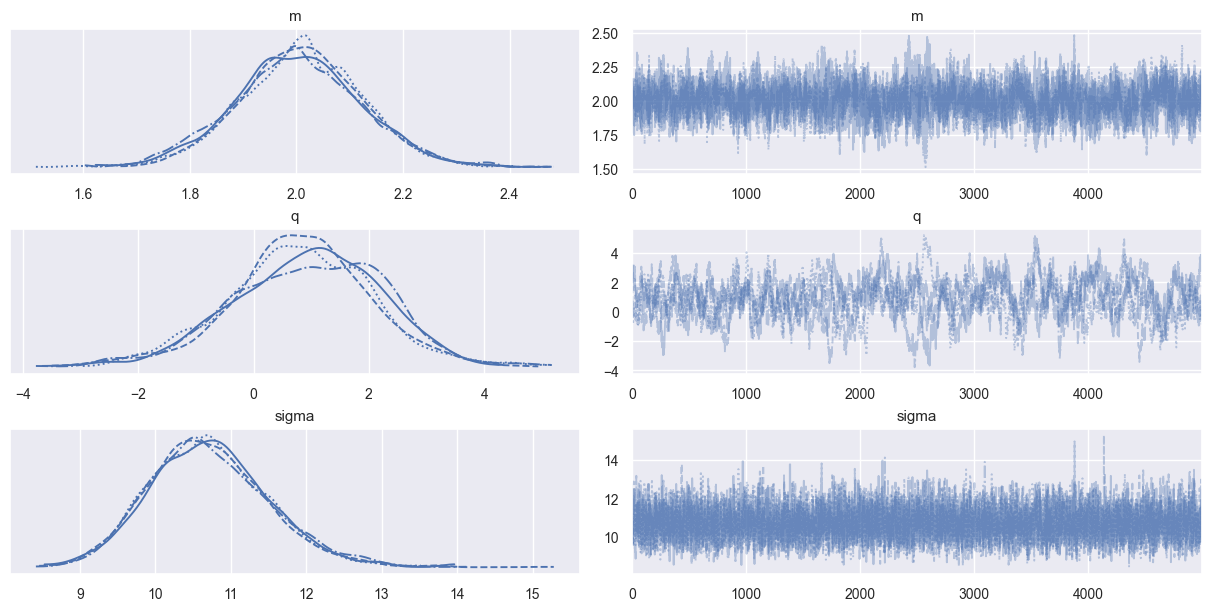

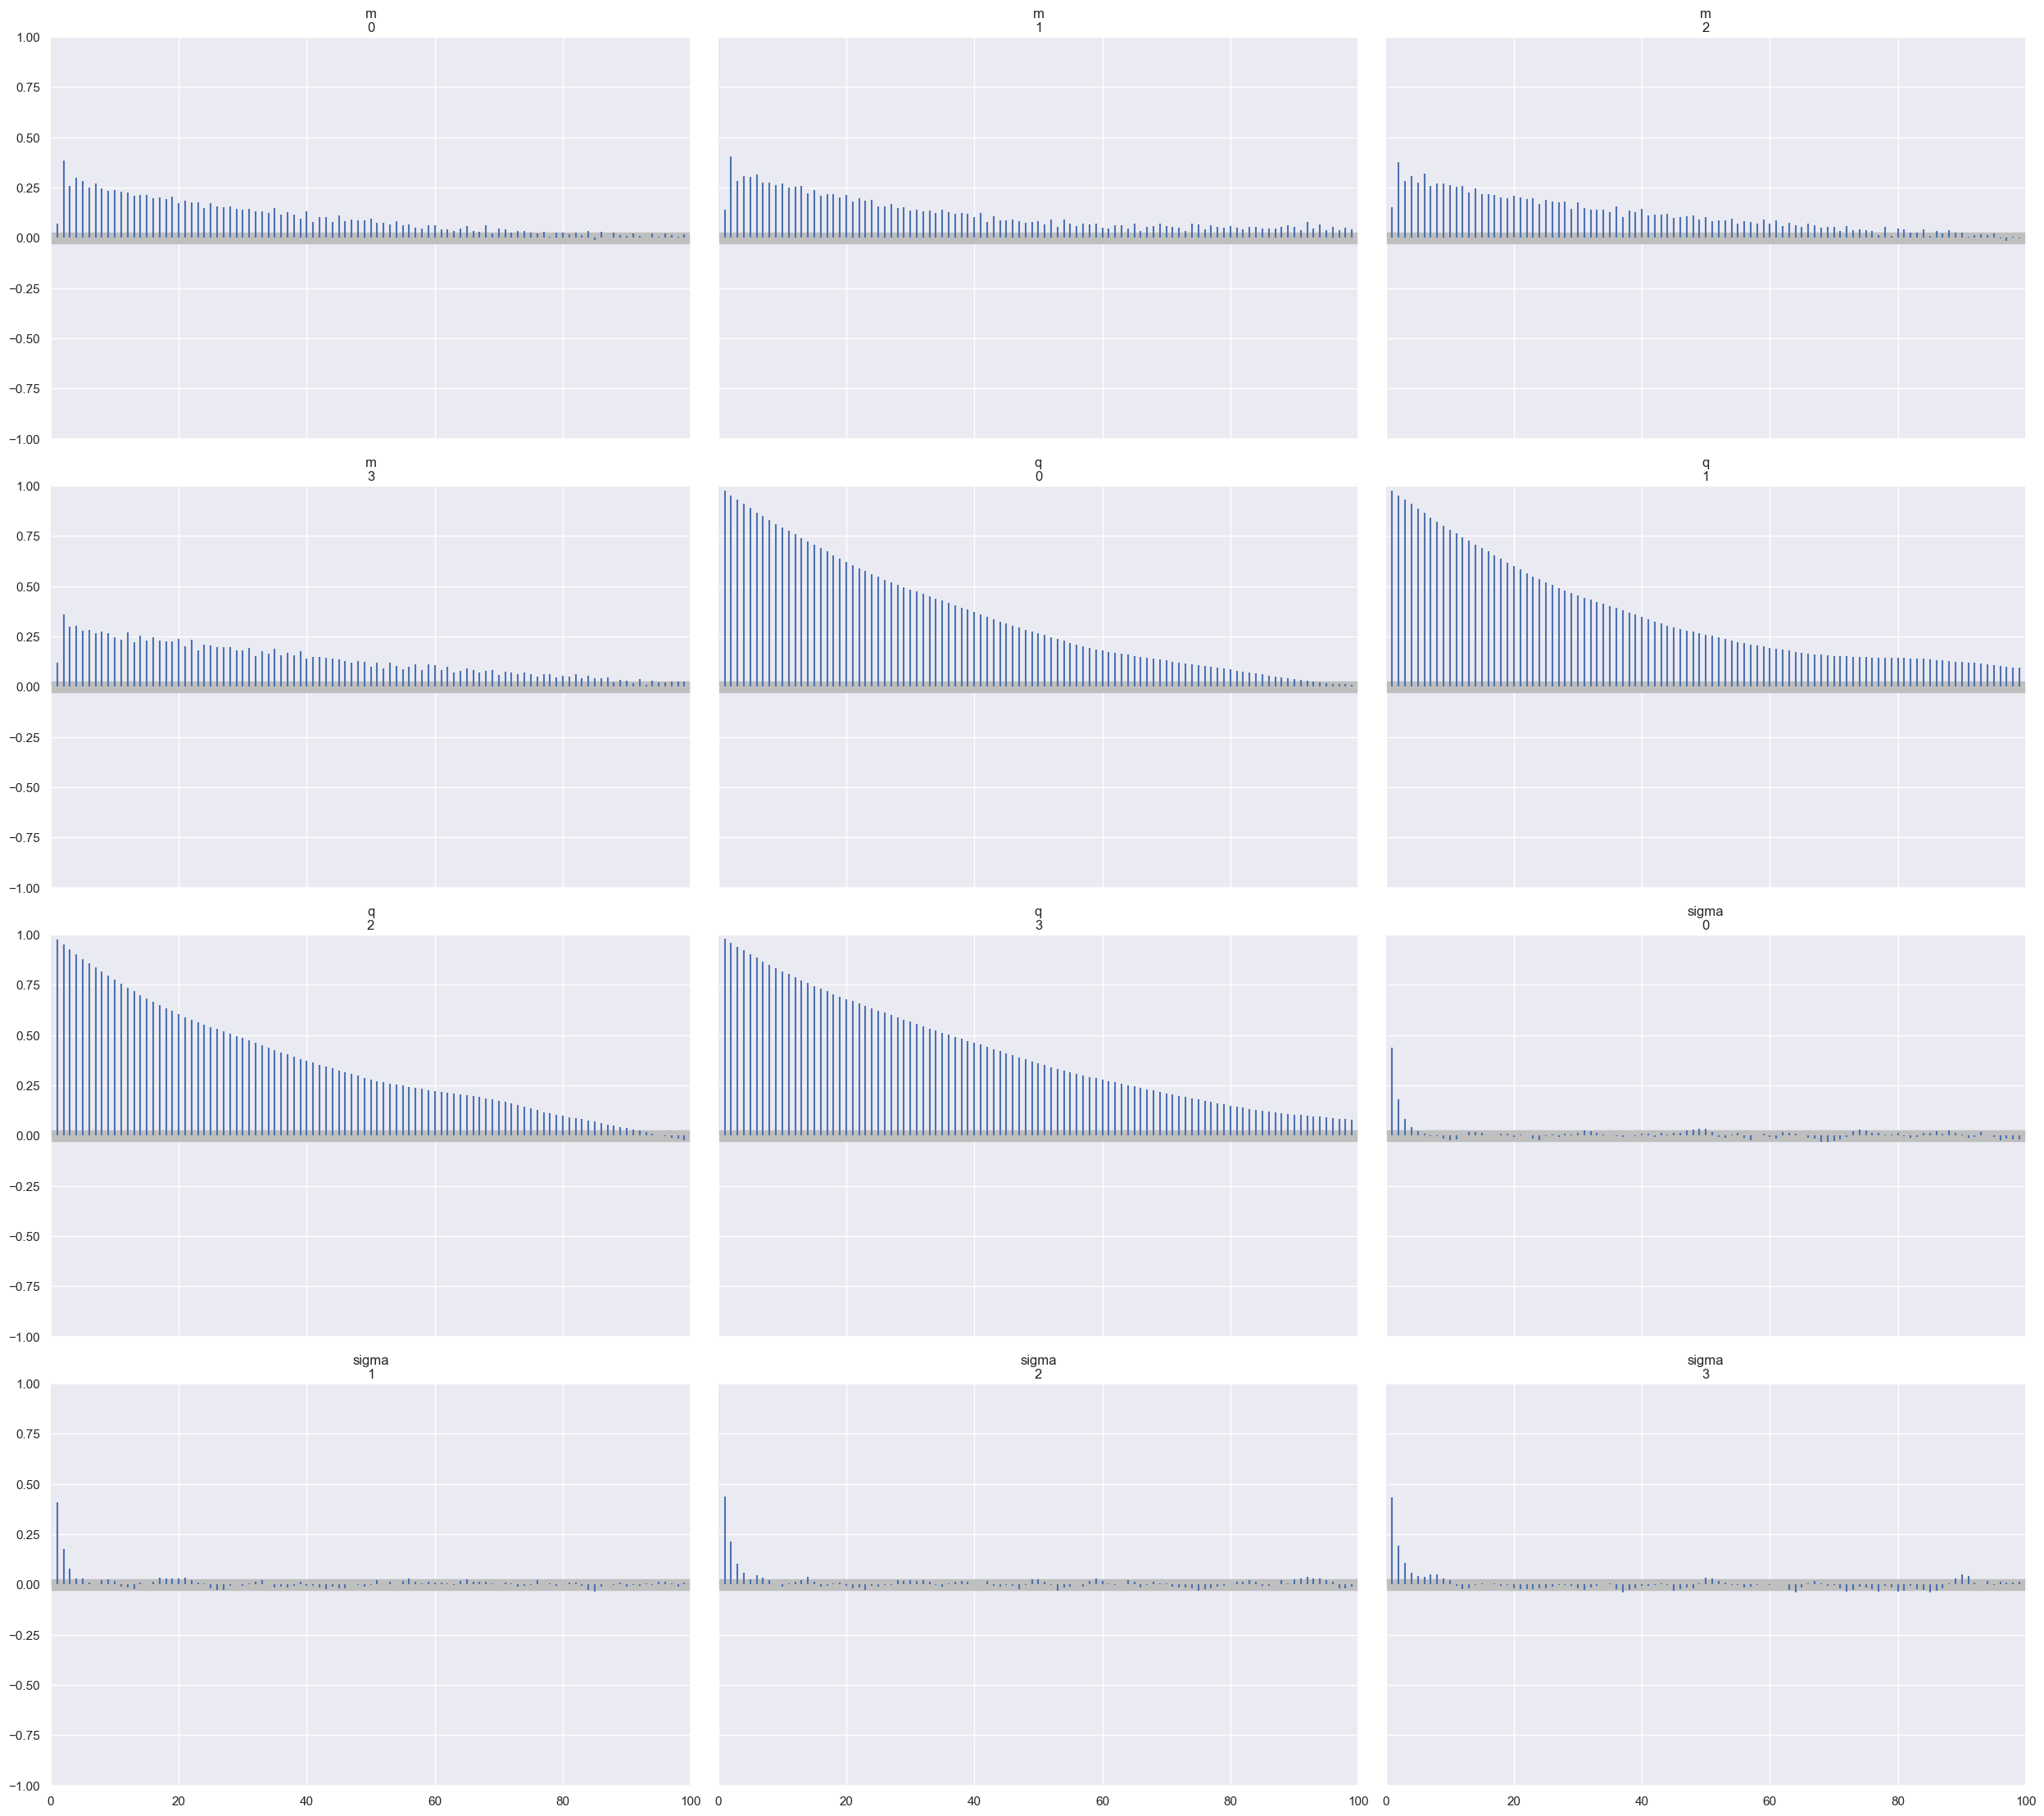

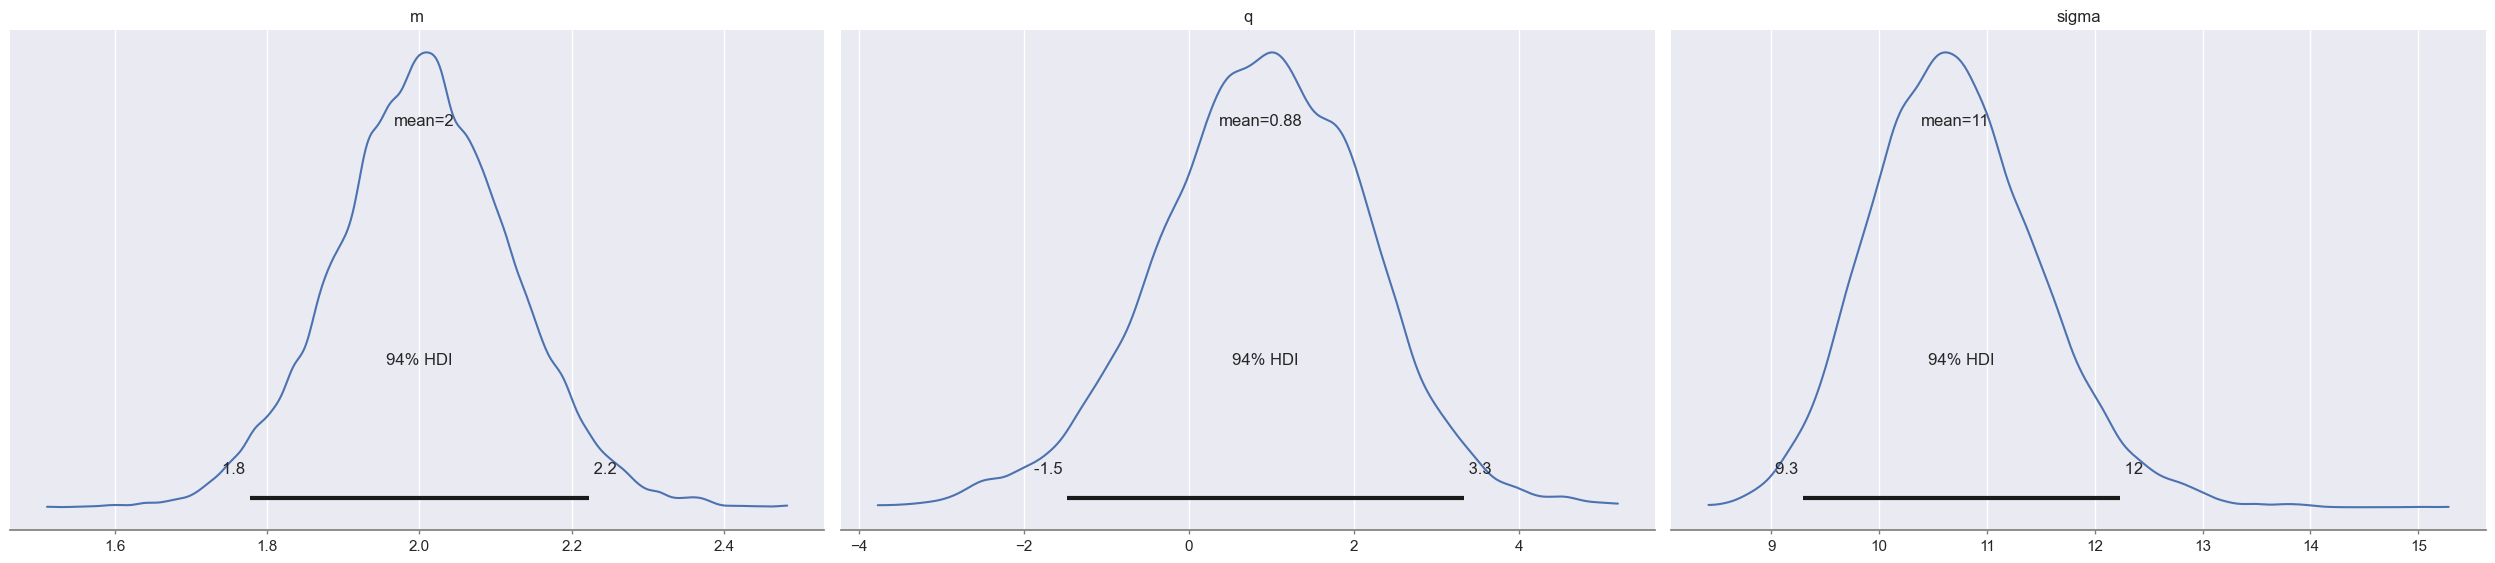

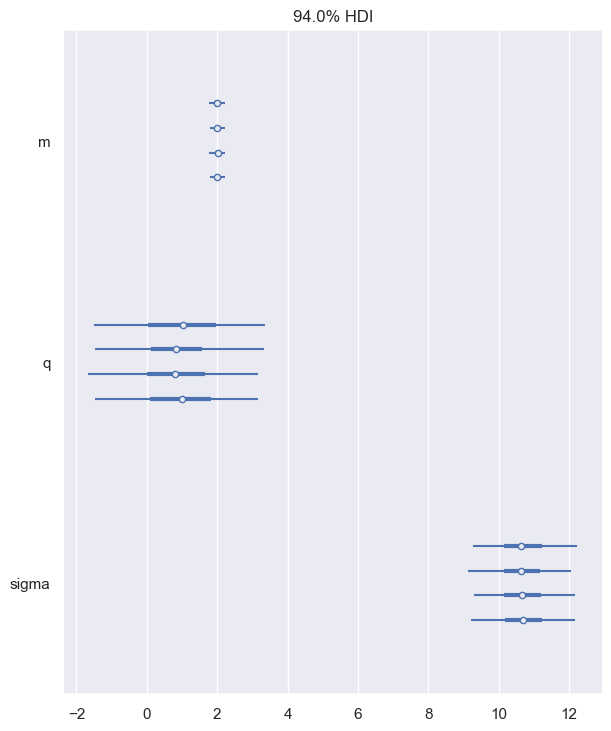

In [14]:
az.plot_trace(inference_data)

az.plot_autocorr(inference_data)

az.plot_posterior(inference_data)

az.plot_forest(inference_data)

An example of autocorrelation with thinning.

Text(0.5, 1.0, 'Autocorrelation with thinning (keeping 1 sample every 3)')

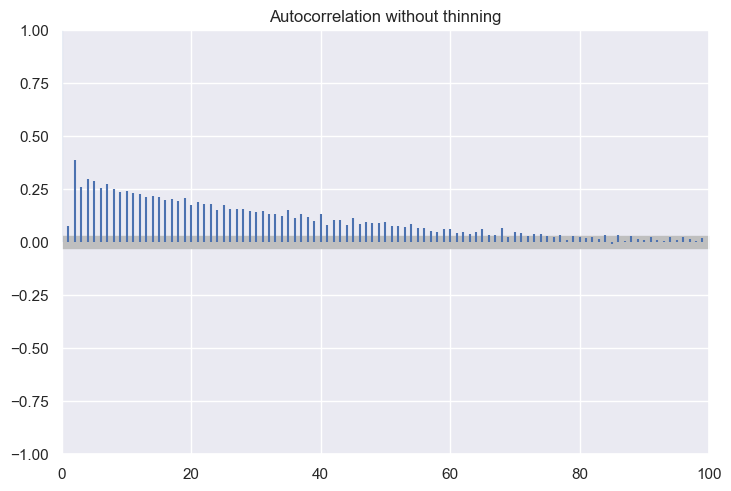

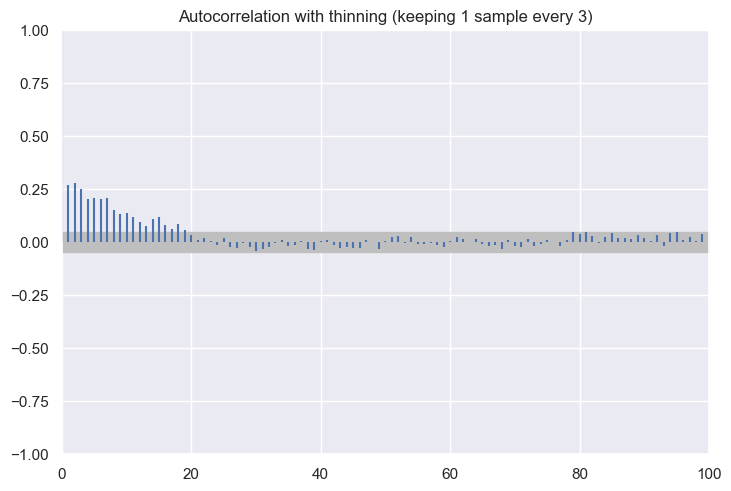

In [15]:
az.plot_autocorr(trace_m_burned[:, 0].numpy().T)

plt.title('Autocorrelation without thinning')

az.plot_autocorr(trace_m_burned[::3, 0].numpy().T)

plt.title('Autocorrelation with thinning (keeping 1 sample every 3)')

Plot the line corresponding to the mean of the posterior samples for each parameter and another line corresponding to other porterior samples drawn randomly from the traces.

In [16]:
def compute_pred(x, m, q):
    return x * m + q

In [17]:
trace_m_burned.shape

TensorShape([5000, 4])

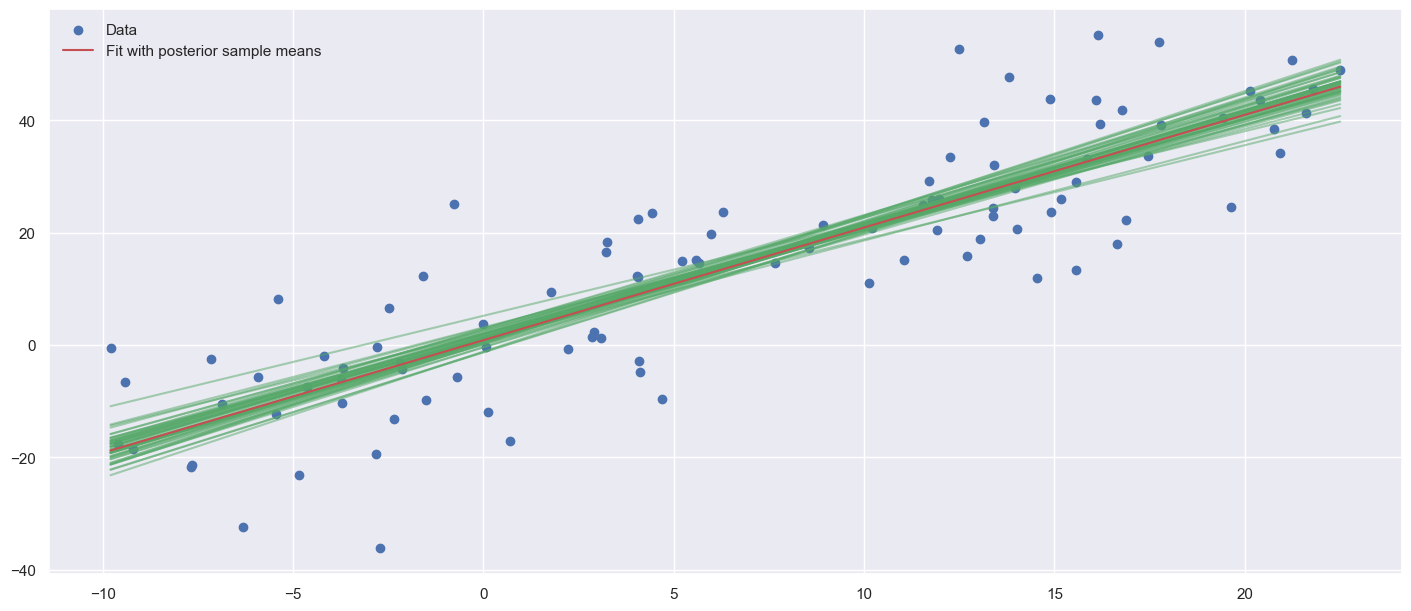

In [18]:
x_plot = np.linspace(x_data.numpy().min(), x_data.numpy().max(), 100)
y_plot = compute_pred(
    x_plot,
    tf.reduce_mean(tf.concat([
        trace_m_burned[:, 0],
        trace_m_burned[:, 1],
        trace_m_burned[:, 2],
        trace_m_burned[:, 3]
    ], axis=-1)),
    tf.reduce_mean(tf.concat([
        trace_q_burned[:, 0],
        trace_q_burned[:, 1],
        trace_q_burned[:, 2],
        trace_q_burned[:, 3]
    ], axis=-1)),
)

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=x_data,
    y=y_data,
    label='Data')

n_param_samples = 50

chain_indices = np.random.choice(trace_m_burned.shape[1], n_param_samples)
sample_indices = np.random.choice(trace_m_burned.shape[0], n_param_samples)

for si, ci in zip(sample_indices, chain_indices):
    plt.plot(
        x_plot,
        compute_pred(x_plot, trace_m_burned[si, ci], trace_q_burned[si, ci]),
        color='g',
        alpha=.5
    )
    
plt.plot(
    x_plot,
    y_plot,
    color='r',
    label='Fit with posterior sample means')

plt.legend()

Generate a synthetic dataset using the means of the posterior distributions or a random sample from the posterior distribution as values for the parameters ($m$, $q$ and $\sigma$).

In [19]:
def generate_synthetic_dataset(x_data, m, q, sigma):
    synth_data_distr = tfd.Independent(
        tfd.Normal(
            loc=x_data * m + q,
            scale=sigma),
        reinterpreted_batch_ndims=1)
    
    return synth_data_distr.sample()

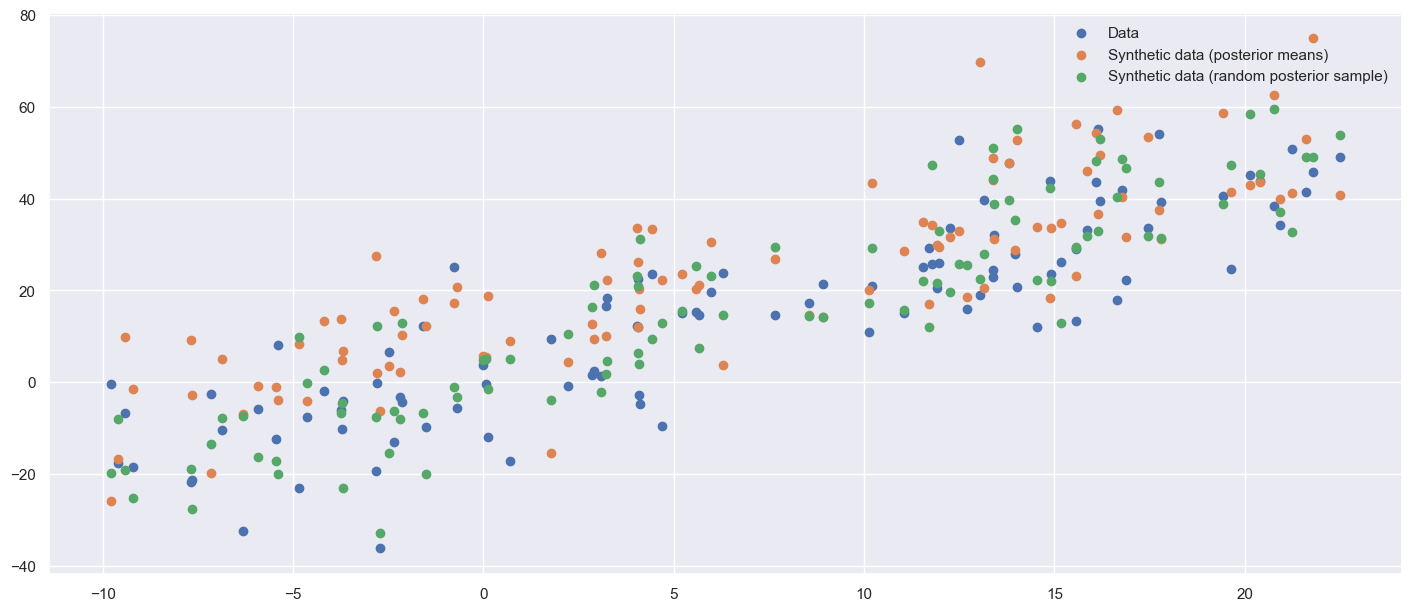

In [20]:
fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=x_data,
    y=y_data,
    label='Data',)

m_synthetic_data = tf.reduce_mean(tf.concat([
    trace_m_burned[:, 0],
    trace_m_burned[:, 1],
    trace_m_burned[:, 2],
    trace_m_burned[:, 3]
], axis=-1))
q_synthetic_data = tf.reduce_mean(tf.concat([
    trace_q_burned[:, 0],
    trace_q_burned[:, 1],
    trace_q_burned[:, 2],
    trace_q_burned[:, 3]
], axis=-1))
sigma_synthetic_data = q_synthetic_data = tf.reduce_mean(tf.concat([
    trace_sigma_burned[:, 0],
    trace_sigma_burned[:, 1],
    trace_sigma_burned[:, 2],
    trace_sigma_burned[:, 3]
], axis=-1))

plt.scatter(
    x=x_data,
    y=generate_synthetic_dataset(x_data, m_synthetic_data, q_synthetic_data, sigma_synthetic_data),
    label='Synthetic data (posterior means)')

chain_index = np.random.choice(trace_m_burned.shape[1])
sample_index = np.random.choice(trace_m_burned.shape[0])

plt.scatter(
    x=x_data,
    y=generate_synthetic_dataset(
        x_data,
        trace_m_burned[sample_index, chain_index],
        trace_q_burned[sample_index, chain_index],
        trace_sigma_burned[sample_index, chain_index]),
    label='Synthetic data (random posterior sample)')

plt.legend(loc='upper right')

## Bayesian piecewise linear regression

This time we start from some data we'll have to manipulate and try to fit a piecewise linear model to it, in a Bayesian way. This model is composed of:
- A turning point.
- Two straight lines intersecting at the turning point, with a continuity condition at the turning point itself.

### Get the data

In [21]:
raw_data = pd.read_csv('../data/linear_regression/piecewise_linear_regression_data.csv')

In [22]:
raw_data.describe()

x              y
count  114839.000000  114839.000000
mean     1778.487273      47.818589
std      1836.427571      17.265918
min         0.000000      21.578900
25%       261.000000      34.214300
50%      1291.000000      44.546700
75%      2690.000000      58.647100
max     11896.000000      95.880000

Text(0, 0.5, 'y')

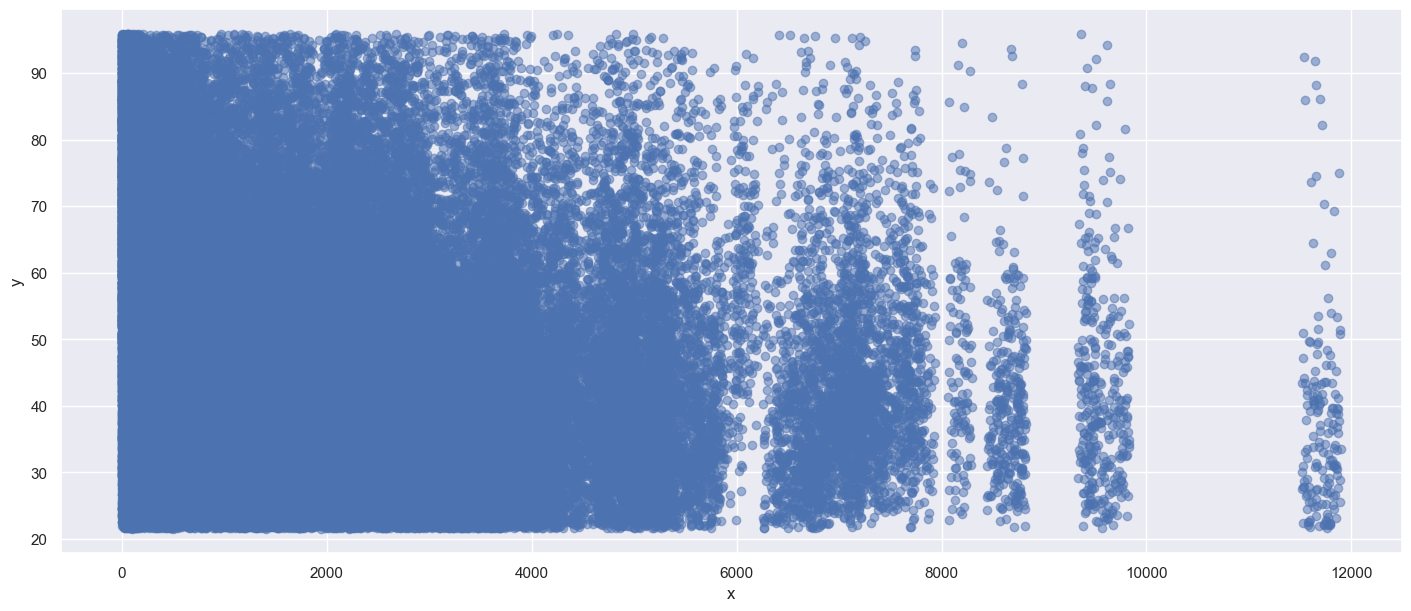

In [23]:
fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=raw_data['x'],
    y=raw_data['y'],
    alpha=0.5,
    label='Data')

plt.xlabel('x')
plt.ylabel('y')

/Users/emanuele_moscato/anaconda3/envs/bayesian-explorations/lib/python3.9/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


Text(468.01587301587307, 0.5, 'y')

<Figure size 1400x600 with 0 Axes>

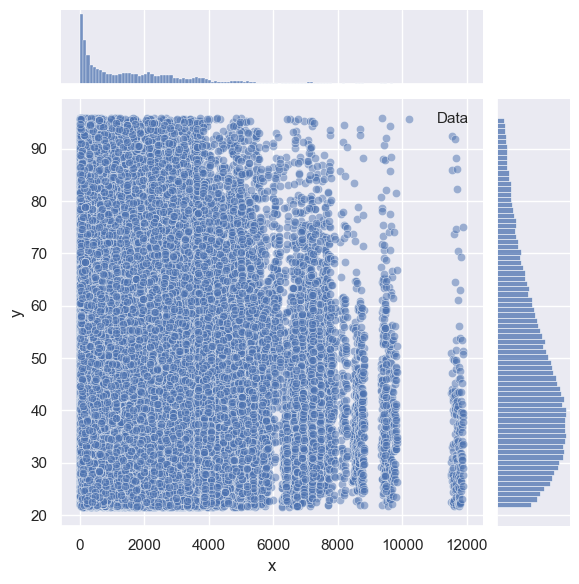

In [24]:
fig = plt.figure(figsize=(14, 6))

sns.set_theme()

sns.jointplot(
    x=raw_data['x'],
    y=raw_data['y'],
    alpha=0.5,
    label='Data')

plt.xlabel('x')
plt.ylabel('y')

The plots indicate that we have many more measurements for small values of $x$ than for big values, plus given a value of $x$ there's a lot of variance in the $y$ values (there are more $y$ values for each $x$ value). We can reduce the noise by taking the mean value of $y$ for each value of $x$.

In [25]:
mean_data = raw_data.groupby('x')['y'].mean().reset_index()

# Impose a cutoff on the x.
mean_data = mean_data[
    (mean_data['x'] < 1500)
    & (mean_data['x'] > 0)
]

mean_data

x          y
1        1  68.406022
2        2  66.808719
3        3  68.991244
4        4  66.367156
5        5  68.029601
...    ...        ...
1495  1495  46.188335
1496  1496  47.955726
1497  1497  45.752977
1498  1498  43.157288
1499  1499  45.920368

[1499 rows x 2 columns]

The data becomes more reasonable. The smaller $x$, the more $y$ values we had in the raw data, so after taking the mean we get a bigger variance for bigger values of $x$ (this is just the fact that if $n_y$ is the number of $y$ values for a given $x$, the standard deviation of the mean goes like $1 / \sqrt{n_y}$). In short, the variance gets bigger as the $x$ gets bigger because the mean is computed on fewer samples.

Text(0, 0.5, 'y')

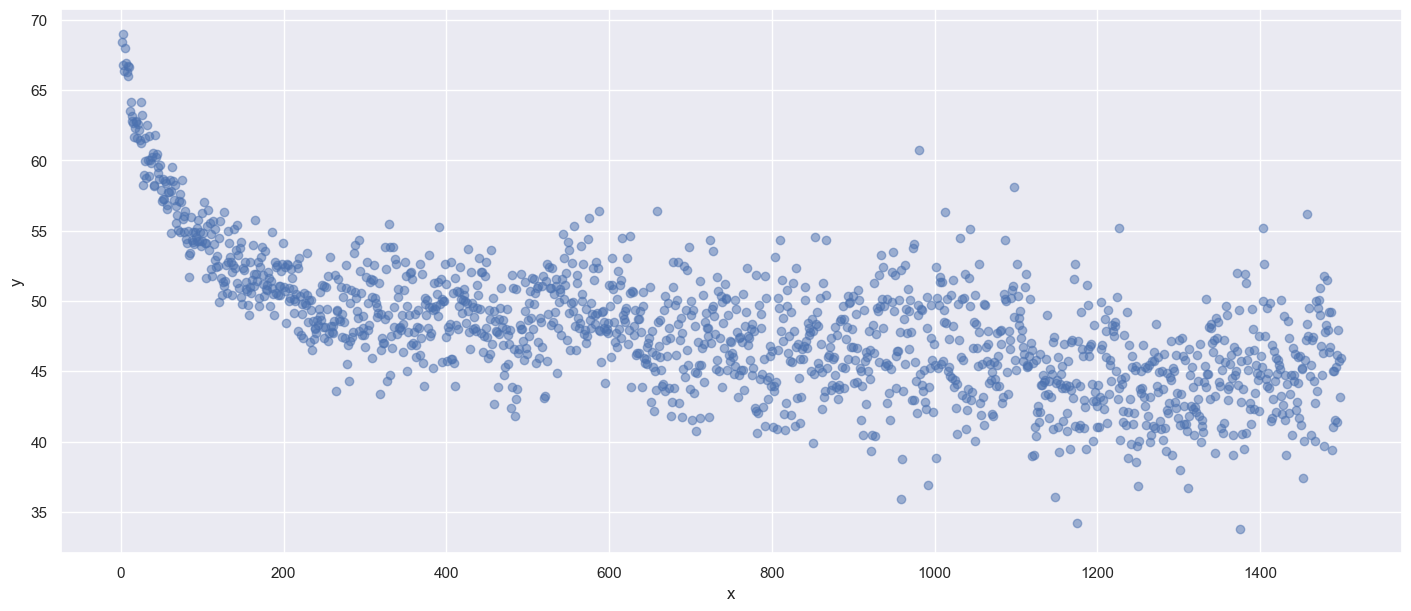

In [26]:
fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=mean_data['x'],
    y=mean_data['y'],
    alpha=0.5,
    label='Data')

plt.xlabel('x')
plt.ylabel('y')

Text(0.5, 1.0, 'St. dev. VS X')

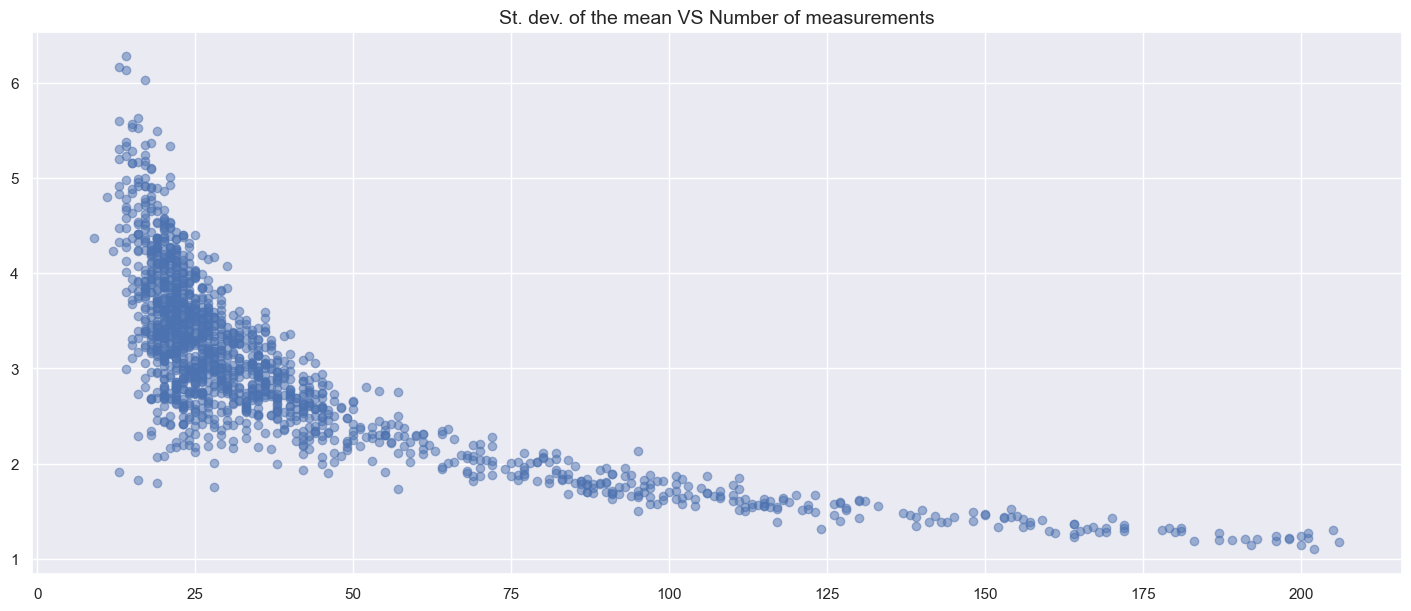

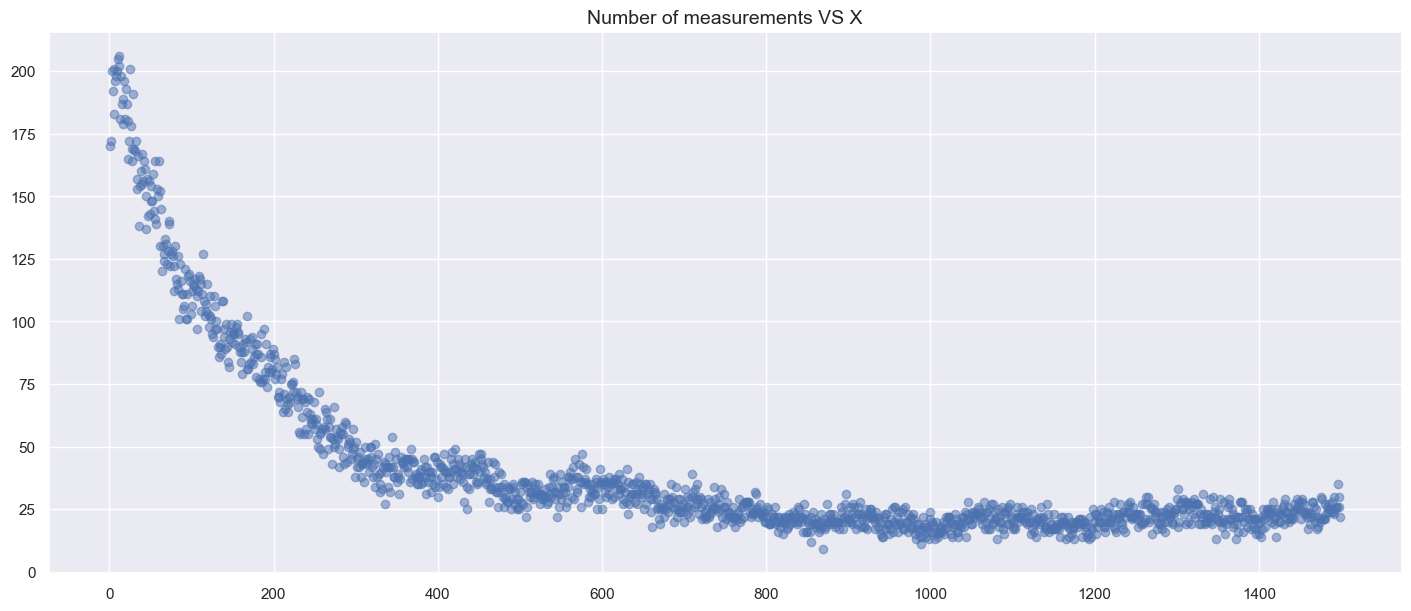

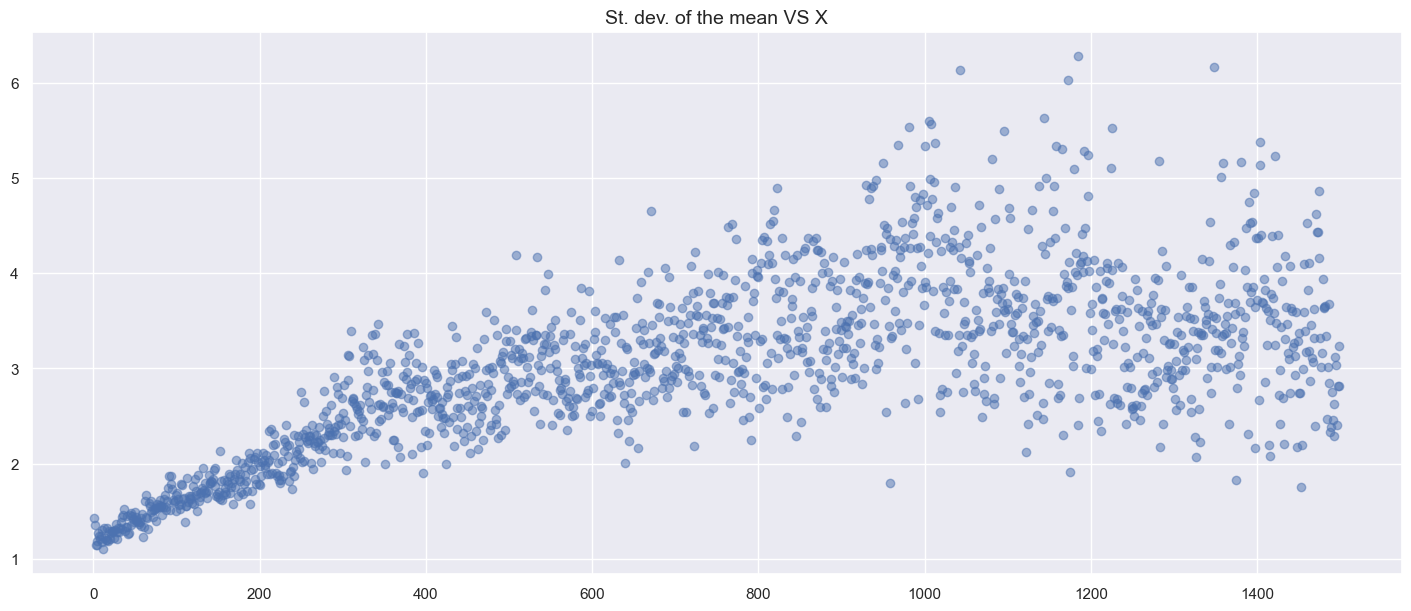

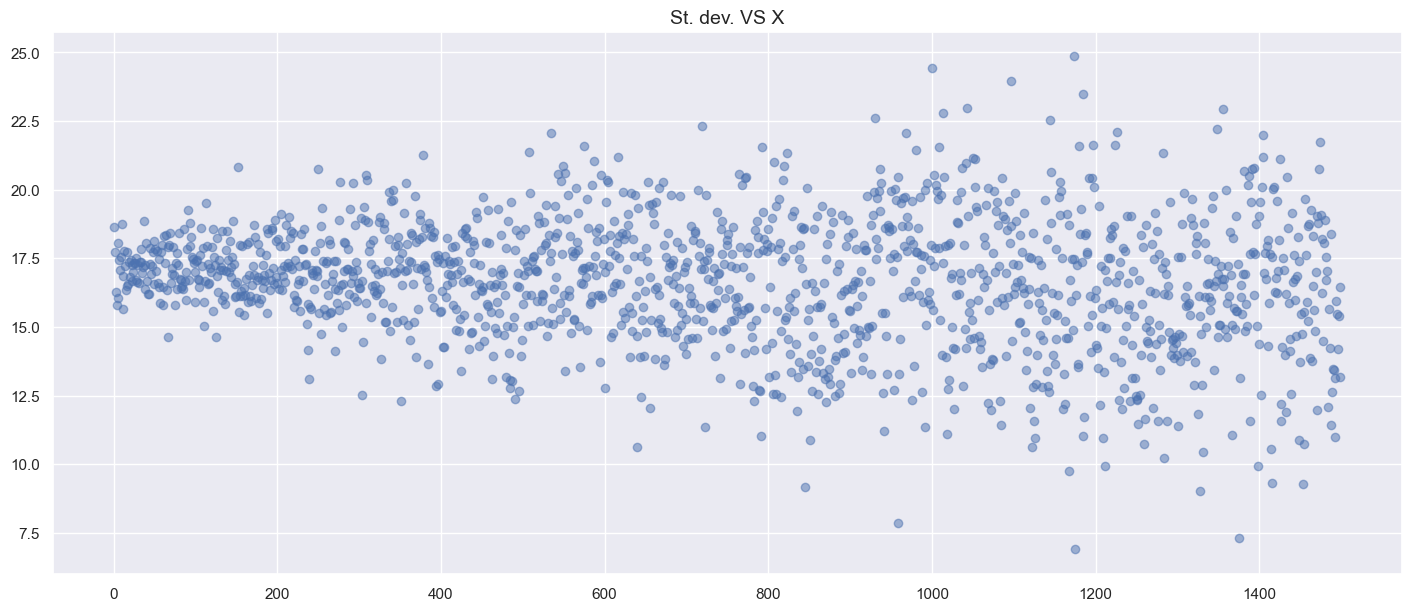

In [27]:
std_vs_n_measurements = raw_data[
    (raw_data['x'] < 1500)
    & (raw_data['x'] > 0)
].groupby('x').agg(
    n_measurements=('y', 'count'),
    y_std=('y', 'std'),
    y_mean=('y', 'mean')
).reset_index()

std_vs_n_measurements['std_of_mean'] = (
    std_vs_n_measurements['y_std']
    / np.sqrt(std_vs_n_measurements['n_measurements'])
)

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=std_vs_n_measurements['n_measurements'],
    y=std_vs_n_measurements['std_of_mean'],
    alpha=0.5,
    label='Data')

plt.title('St. dev. of the mean VS Number of measurements', fontsize=14)

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=std_vs_n_measurements['x'],
    y=std_vs_n_measurements['n_measurements'],
    alpha=0.5,
    label='Data')

plt.title('Number of measurements VS X', fontsize=14)

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=std_vs_n_measurements['x'],
    y=std_vs_n_measurements['std_of_mean'],
    alpha=0.5,
    label='Data')

plt.title('St. dev. of the mean VS X', fontsize=14)

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=std_vs_n_measurements['x'],
    y=std_vs_n_measurements['y_std'],
    alpha=0.5,
    label='Data')

plt.title('St. dev. VS X', fontsize=14)

Hypothesis: there are probably two effects influencing the observed standard deviation of the mean of $y$,
- The dependence from the number of samples $n$ (given a value of $x$), which in case each value of $y$ (from the raw data) is normally distributed around a mean value should scale like $1/\sqrt{n}$.
- A further dependence from $x$, so that the $y$ from the raw data, for a given $x$, are not normally distributed with the same variance. This can be seen in the last plot, where we see that the standard deviation has a decreasing trend as $x$ increases.

Idea 1 (to do):
1. Perform a fit for the number of measurements (`n_measurements`) as a function of $x$.
2. Perform another fit for the standard deviation of $y$ (`std`) as a function of $x$.
3. Combine the two fits above to obtain the standard defiation of the mean of $y$ as a function of $x$,
$$
\text{std}(\mathbb{E}(y)) = \frac{1}{\texttt{n_measurements}(x)}
$$
4. Use this function for the scale parameter of the normal distribution generating the data according to the modeling hypothesis.

Idea 2 (to do):
- Is it possible to find a transformation of the data that simplifies this?

### Piecewise linear regression

In [28]:
x_values = tf.cast(mean_data['x'], tf.float32)
y_values = tf.cast(mean_data['y'].values, tf.float32)

In [29]:
joint_distr_switchpoint = tfd.JointDistributionSequential([
    tfd.Normal(loc=-0.15, scale=0.1),  # m1
    tfd.Normal(loc=70., scale=4.),  # q1
    tfd.Normal(loc=-0.03, scale=0.02),  # m2
    tfd.Normal(loc=100., scale=15.),  # tau
    lambda tau, m2, q1, m1: tfd.Independent(
        tfd.Normal(
            # loc=tf.transpose((
            #     (
            #         m1 * tf.expand_dims(x_values, -1) + q1
            #     ) * tf.cast(tf.expand_dims(x_values, -1) < tau, tf.float32)
            # ) + (
            #     (m2 * tf.expand_dims(x_values, -1) + (m1 - m2) * tau + q1)
            #     * tf.cast(tf.expand_dims(x_values, -1) >= tau, tf.float32)
            # )),
            # New attempt.
            (
                tf.where(
                    x_values < tf.expand_dims(tau, -1),
                    tf.expand_dims(m1, -1),
                    tf.expand_dims(m2, -1)
                ) * x_values
                + tf.where(
                    x_values < tf.expand_dims(tau, -1),
                    tf.expand_dims(q1, -1),
                    tf.expand_dims((m1 - m2) * tau + q1, -1)
                )
            ),
            scale=3.
        ),
        reinterpreted_batch_ndims=1
    )
])

# Returns a tensor of shape batch_shape, where batch_shape is assumed to be
# the shape of the tensors representing batch_shape values for each parameters
# (needed to run multiple chains in parallel).
joint_log_prob_switchpoint_closure = (
    lambda m1, q1, m2, tau: joint_distr_switchpoint.log_prob(m1, q1, m2, tau, y_values)
)

In [32]:
distr_switchpoint, samples_switchpoint = joint_distr_switchpoint.sample_distributions()

distr_switchpoint[-1]

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[1499] dtype=float32>

Randomly sample the joint log prob (sampling values from the priors for the parameters) and plot the results (synthetic data and mean of the Normal distribution, which represents the piecewise constant function around which points are distributed).

tau = 95.77204895019531
Joint log prob of original data: -8741.8544921875


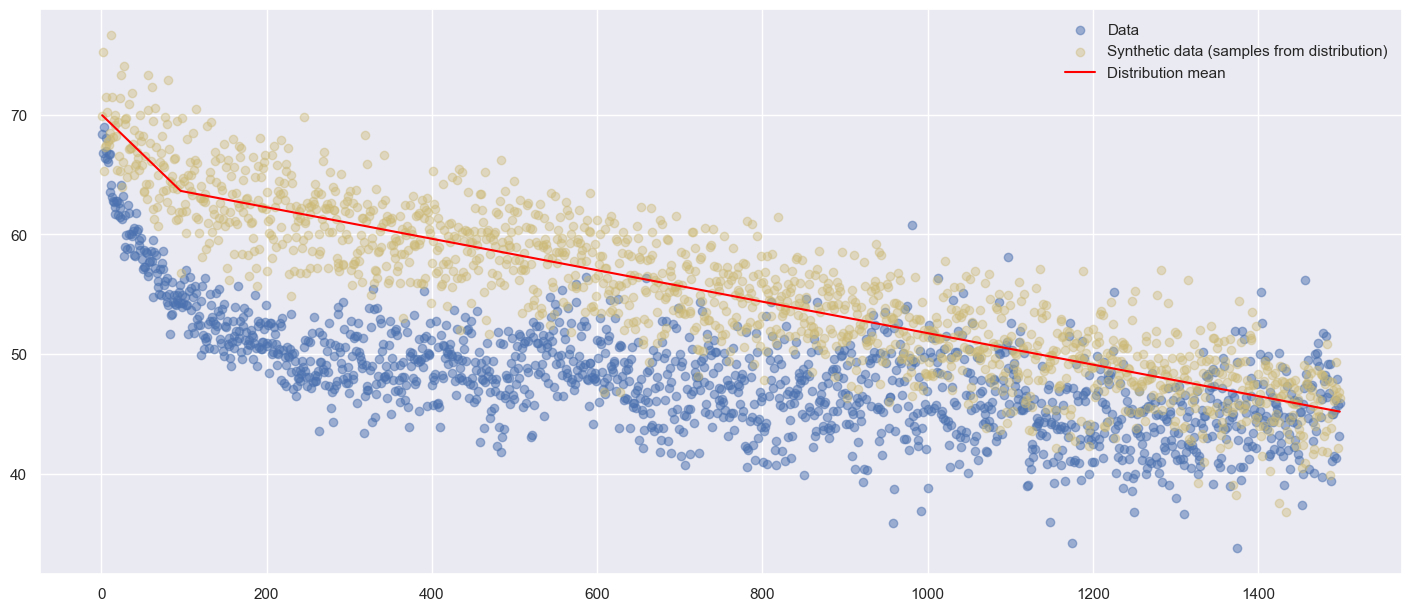

In [34]:
distr_switchpoint, samples_switchpoint = joint_distr_switchpoint.sample_distributions()

y_mean = distr_switchpoint[-1].mean()#[0, :]
m1, q1, m2, tau, y = samples_switchpoint

print(f'tau = {tau}')
print(
    'Joint log prob of original data: '
    f'{joint_distr_switchpoint.log_prob(m1, q1, m2, tau, y_values)}')

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=mean_data['x'],
    y=mean_data['y'],
    alpha=0.5,
    label='Data')

plt.scatter(
    x_values.numpy(),
    y.numpy(),
    alpha=.4,
    color='y',
    label='Synthetic data (samples from distribution)')

plt.plot(
    x_values.numpy(),
    y_mean.numpy(),
    color='red',
    label='Distribution mean')

plt.legend()

The above procedure can be expanded into a **prior predictive check**, which is useful to underestand if our choice of priors is able to capture the observed data, before conditioning the model on the observed data itself. In particular, given the set $\theta$ of model parameters, with prior $p(\theta)$, and the likelihood $p(Y | \theta)$, the prior predictive distribution of the data $Y$ is defined as
$$
p(Y) \equiv \int \mathrm{d}\theta\,p(Y | \theta)\,p(\theta)\,.
$$
This integral is usually impossible to compute analytically (if $Y$ is the observed data, it's actually the usual joint probability of observed data and parameters one needs to approximate to get the posterior distribution), but we can give a Monte Carlo approximation of it: if $\lbrace \theta_i \rbrace_{i=1, \ldots, n}$ are $n$ sets of values for the parameters sampled from the prior distribution $p(\theta)$, then we have
$$
p(Y) \equiv \int \mathrm{d}\theta\,p(Y | \theta)\,p(\theta)\,\simeq \sum_{i=1}^n p(Y | \theta_i)\,.
$$

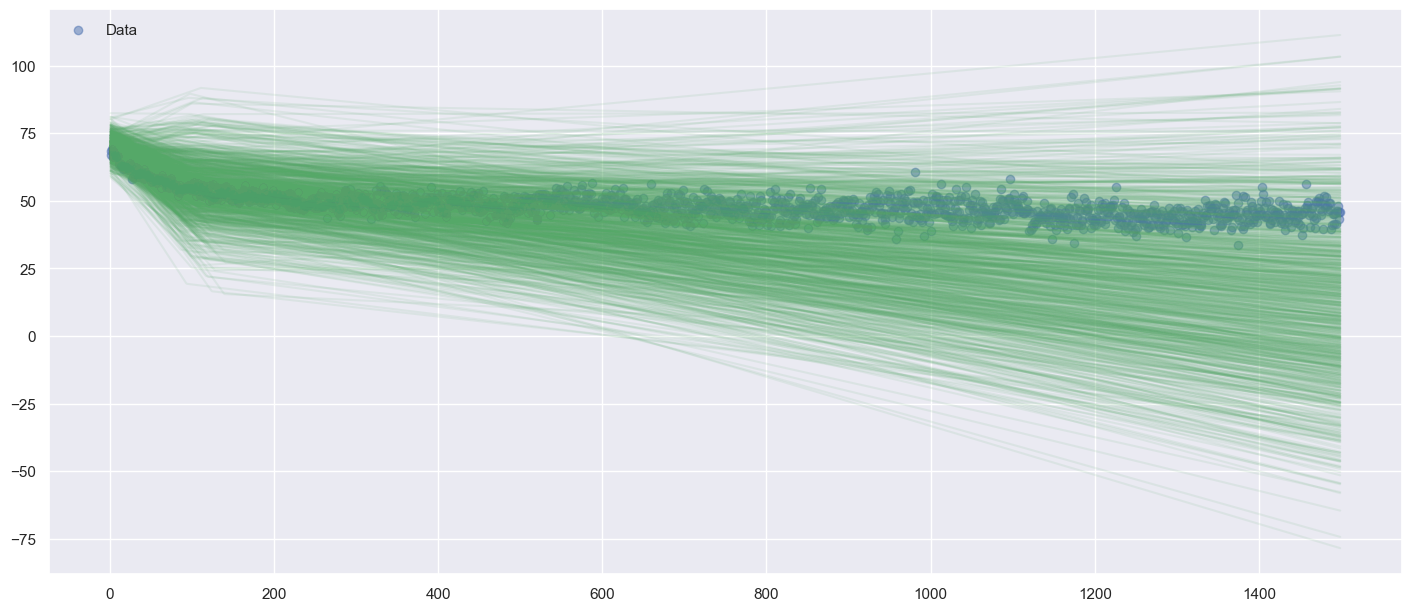

In [35]:
# Prior predictive check.
n_prior_samples = 1000

y_means = joint_distr_switchpoint.sample_distributions(n_prior_samples)[0][-1].mean()

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=mean_data['x'],
    y=mean_data['y'],
    alpha=0.5,
    label='Data')

for i in range(n_prior_samples):
    plt.plot(
        x_values.numpy(),
        y_means[i, :].numpy(),
        color='g',
        alpha=0.1
    )

plt.legend()

In [36]:
n_chains = 4

test_state = [
    -0.14 * tf.ones(shape=(n_chains)),
    70.7 * tf.ones(shape=(n_chains)),
    -0.02 * tf.ones(shape=(n_chains)),
    64.6 * tf.ones(shape=(n_chains)),
]

test_state

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.14, -0.14, -0.14, -0.14], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([70.7, 70.7, 70.7, 70.7], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.02, -0.02, -0.02, -0.02], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([64.6, 64.6, 64.6, 64.6], dtype=float32)>]

In [38]:
joint_log_prob_switchpoint_closure(*test_state)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-6744.5605, -6744.5605, -6744.5605, -6744.5605], dtype=float32)>

In [39]:
initial_chain_state = [    
    -0.07 * tf.ones(shape=(n_chains)),
    63. * tf.ones(shape=(n_chains)),
    -0.007 * tf.ones(shape=(n_chains)),
    70. * tf.ones(shape=(n_chains)),
]
# initial_chain_state = joint_distr_switchpoint.sample(n_chains)[:-1]

initial_chain_state

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.07, -0.07, -0.07, -0.07], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([63., 63., 63., 63.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.007, -0.007, -0.007, -0.007], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([70., 70., 70., 70.], dtype=float32)>]

In [40]:
number_of_steps = 10000
burnin = 5000
leapfrog_steps=3

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),  # Maps R to R (m1).
    tfp.bijectors.Identity(),  # Maps R to R (q1).
    tfp.bijectors.Identity(),  # Maps R to R (m2).
    tfp.bijectors.Identity()  # Maps R to R (tau).
]
# unconstraining_bijectors_2 = [
#     tfp.bijectors.Identity(),  # Maps R to R (m1).
#     tfp.bijectors.Identity(),  # Maps R to R (q1).
#     tfp.bijectors.Identity(),  # Maps R to R (m2).
#     tfp.bijectors.Identity(),  # Maps R to R (tau).
#     tfp.bijectors.Exp()  # Maps R to (0, +oo) (sigma).
# ]

# Initialize the step_size. (It will be automatically adapted.)
step_size = tf.Variable(.1, dtype=tf.float32)

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=joint_log_prob_switchpoint_closure,
        num_leapfrog_steps=3,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
print('Sampling started')

counter = itertools.count(1)

[
    trace_m1,
    trace_q1,
    trace_m2,
    trace_tau
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps + burnin,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc,
    trace_fn=trace_stuff
)

print('Sampling finished')

trace_m1_burned = trace_m1[burnin:, :]
trace_q1_burned = trace_q1[burnin:, :]
trace_m2_burned = trace_m2[burnin:, :]
trace_tau_burned = trace_tau[burnin:, :]

inference_data = az.convert_to_inference_data({
    'm1': tf.transpose(trace_m1_burned),
    'q1': tf.transpose(trace_q1_burned),
    'm2': tf.transpose(trace_m2_burned),
    'tau': tf.transpose(trace_tau_burned),
})

# posterior_means_switchpoint = {
#     'm1': tf.reduce_mean(trace_m1_burned),
#     'q1': tf.reduce_mean(trace_q1_burned),
#     'm2': tf.reduce_mean(trace_m2_burned),
#     'tau': tf.reduce_mean(trace_tau_burned),
#     'sigma': tf.reduce_mean(trace_sigma_burned)}

/Users/emanuele_moscato/anaconda3/envs/bayesian-explorations/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/internal/util.py:363: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  warnings.warn(


Sampling started
Step 100, state: [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.15984432, -0.15576892, -0.1559404 , -0.15559277], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([63.012573, 63.04609 , 63.026318, 62.952126], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.00595793, -0.00629201, -0.00627106, -0.00628472], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([69.97755 , 69.99834 , 69.975235, 69.99442 ], dtype=float32)>]
Step 200, state: [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.15648697, -0.16145281, -0.15973258, -0.1606728 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([63.013527, 63.038986, 63.019516, 62.943153], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.00621961, -0.00565366, -0.00596808, -0.00570099], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([69.97178 , 70.00193 , 69.97079 , 69.995926], dtype=float32)>]
Ste

In [41]:
inference_data

Inference data with groups:
	> posterior

In [42]:
az.summary(inference_data)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1   -0.159  0.002  -0.164   -0.154      0.001     0.00      21.0     129.0   
q1   62.999  0.081  62.842   63.075      0.040     0.03       5.0      15.0   
m2   -0.006  0.000  -0.006   -0.006      0.000     0.00     641.0    1476.0   
tau  69.966  0.030  69.915   70.021      0.014     0.01       5.0      13.0   

     r_hat  
m1    1.15  
q1    2.42  
m2    1.01  
tau   2.43

In [43]:
kernel_results.inner_results.is_accepted.numpy().mean(), step_size

(0.8054166666666667,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.00017152252>)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

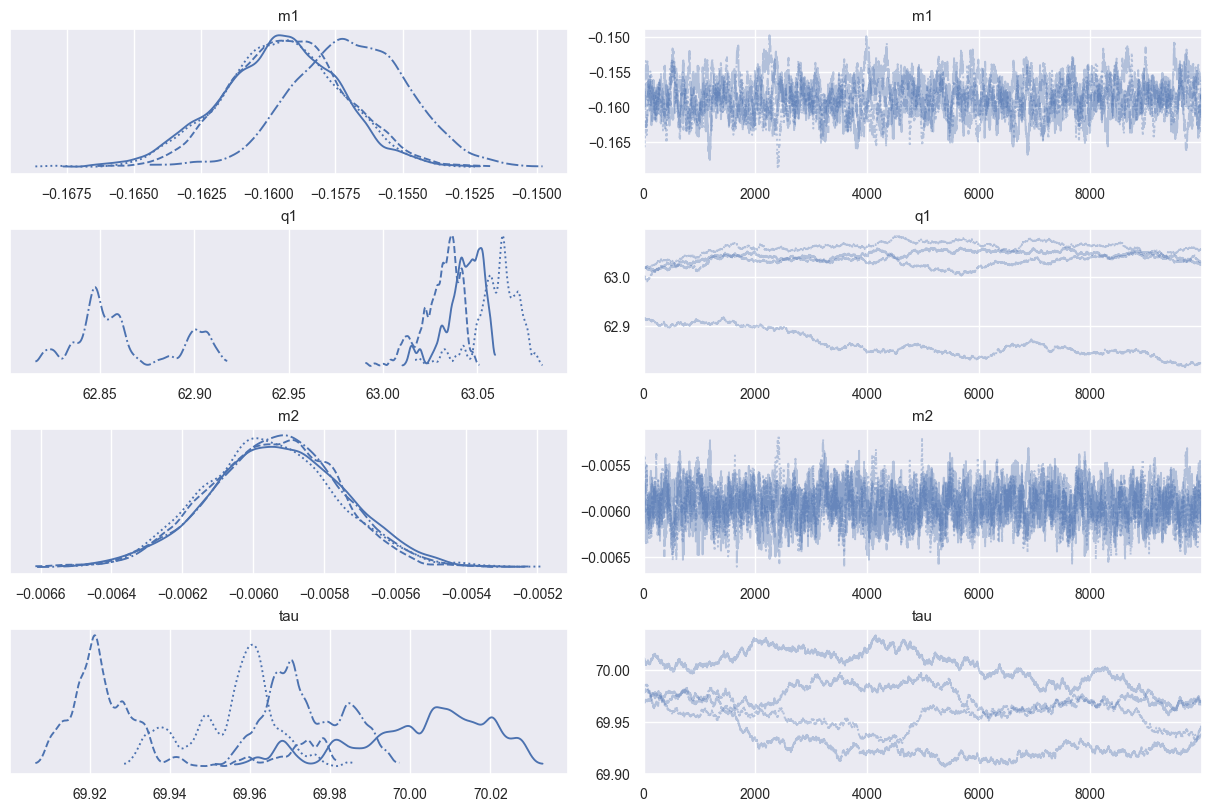

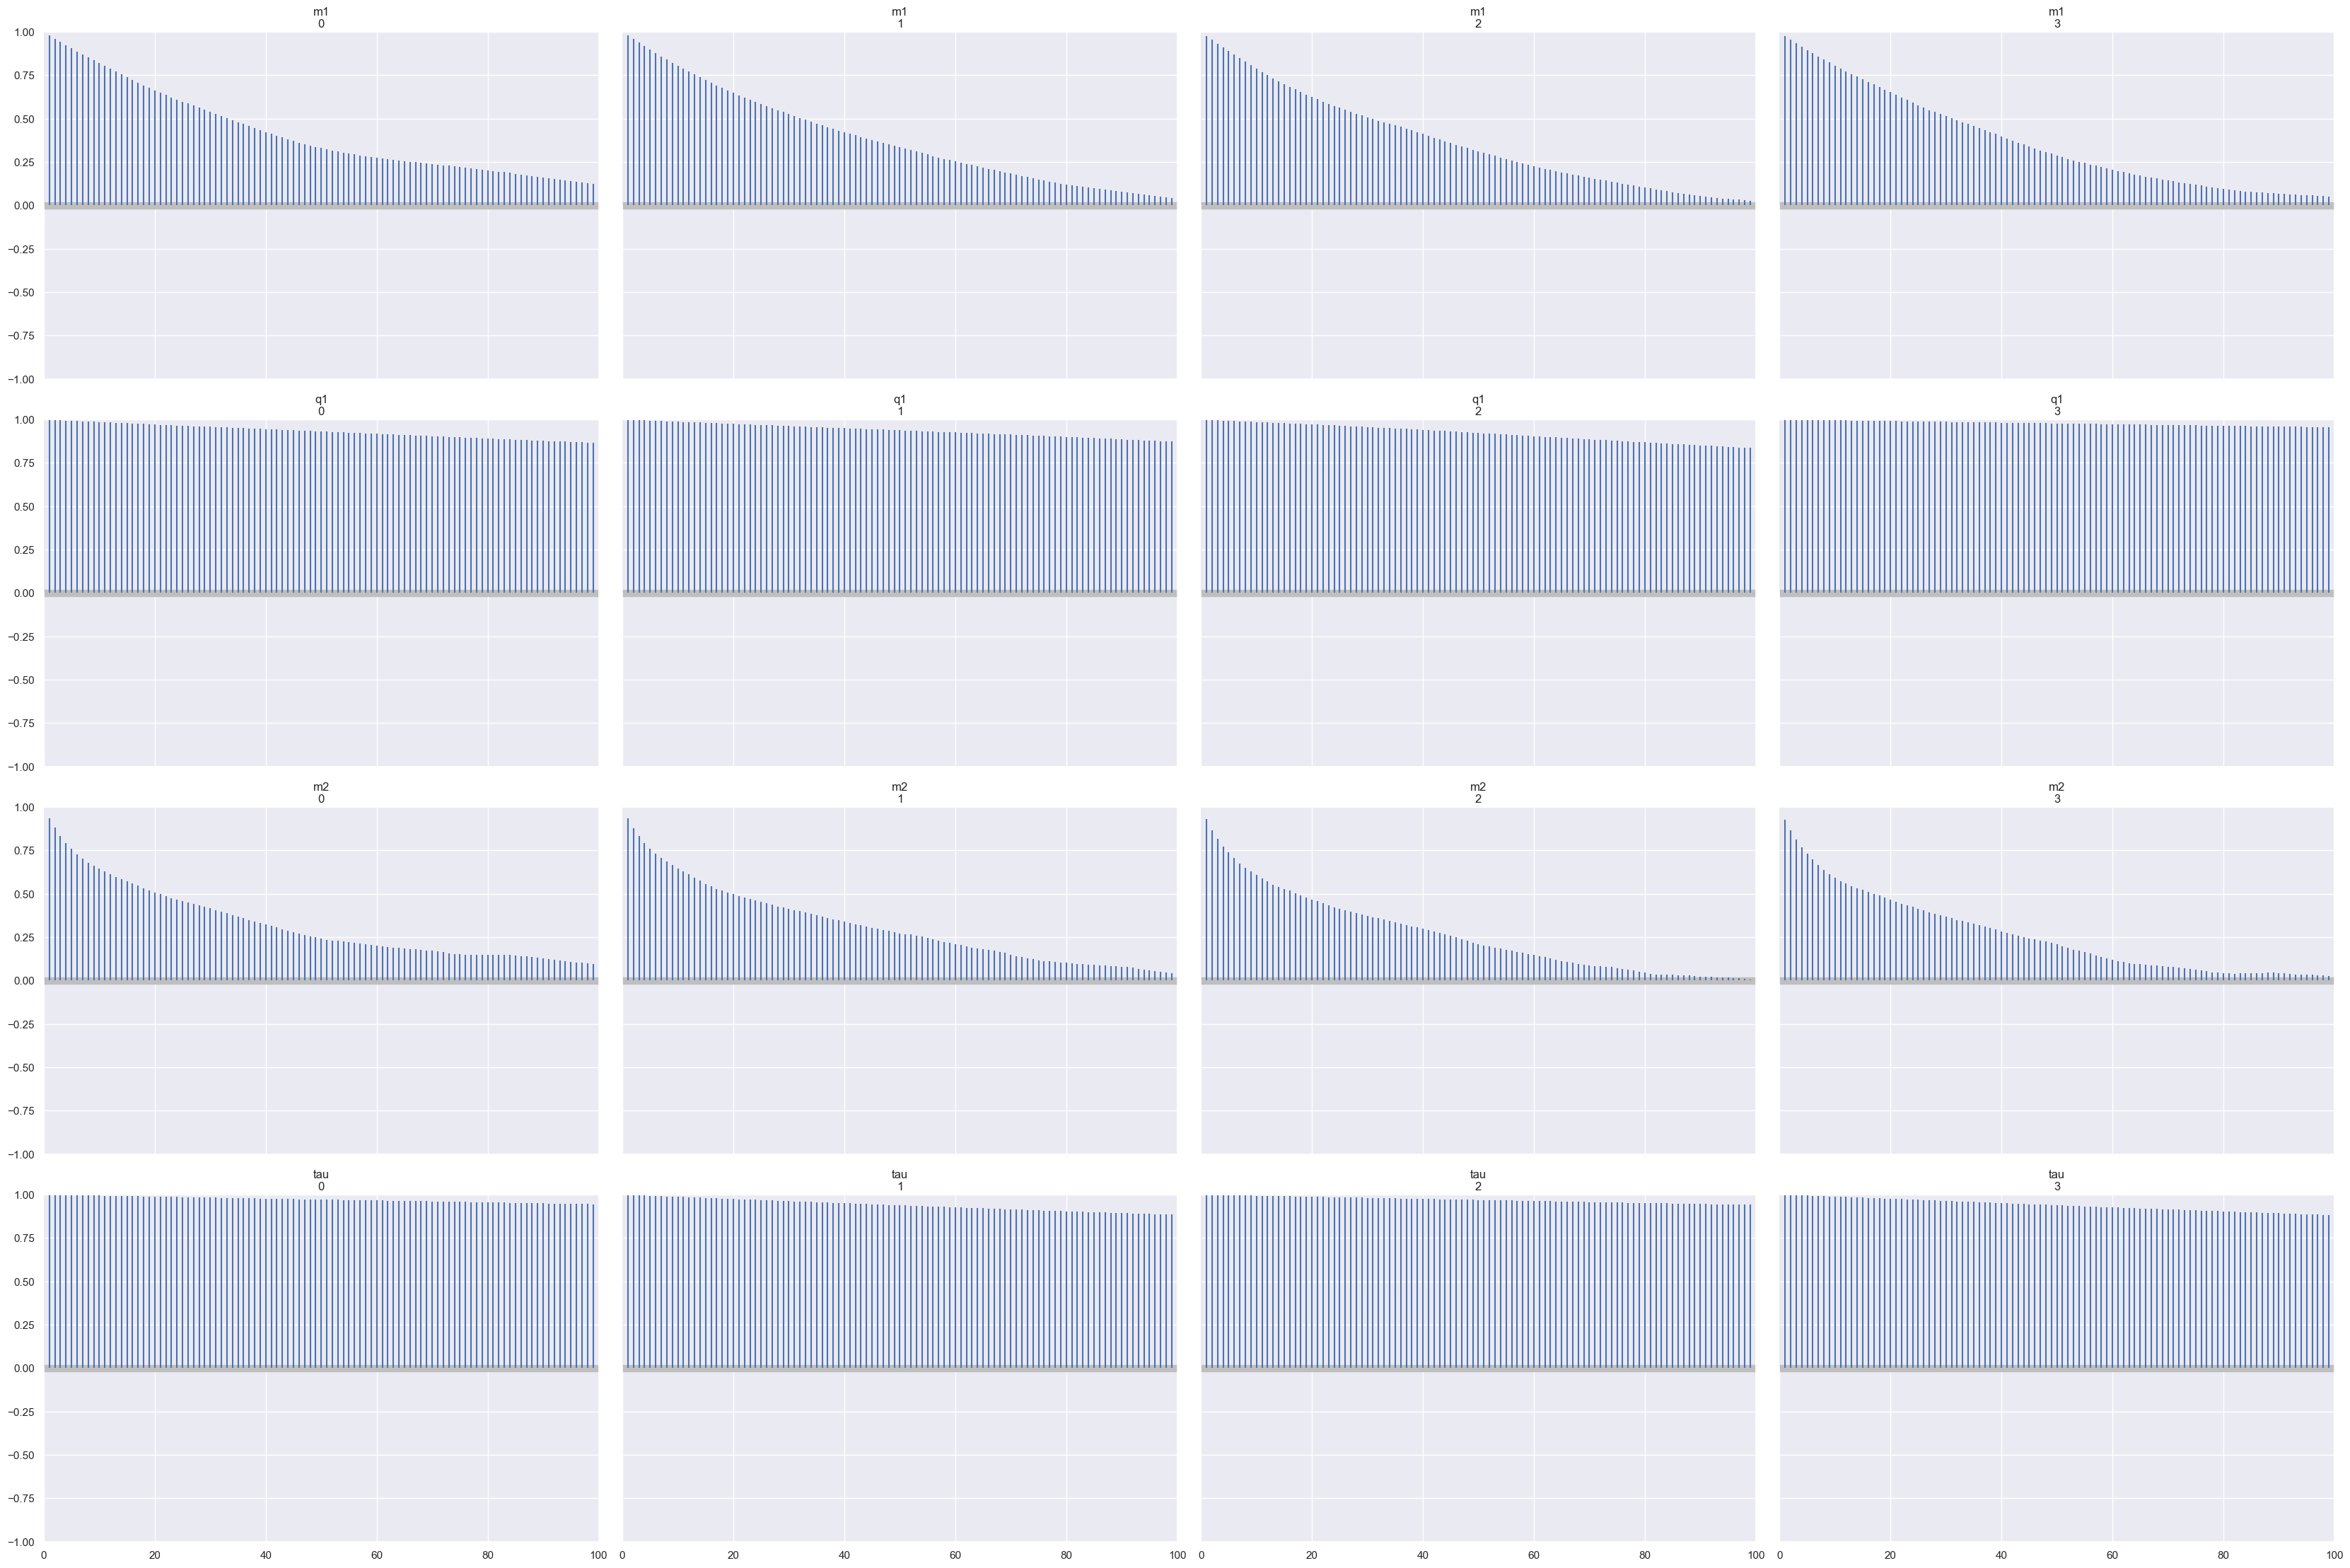

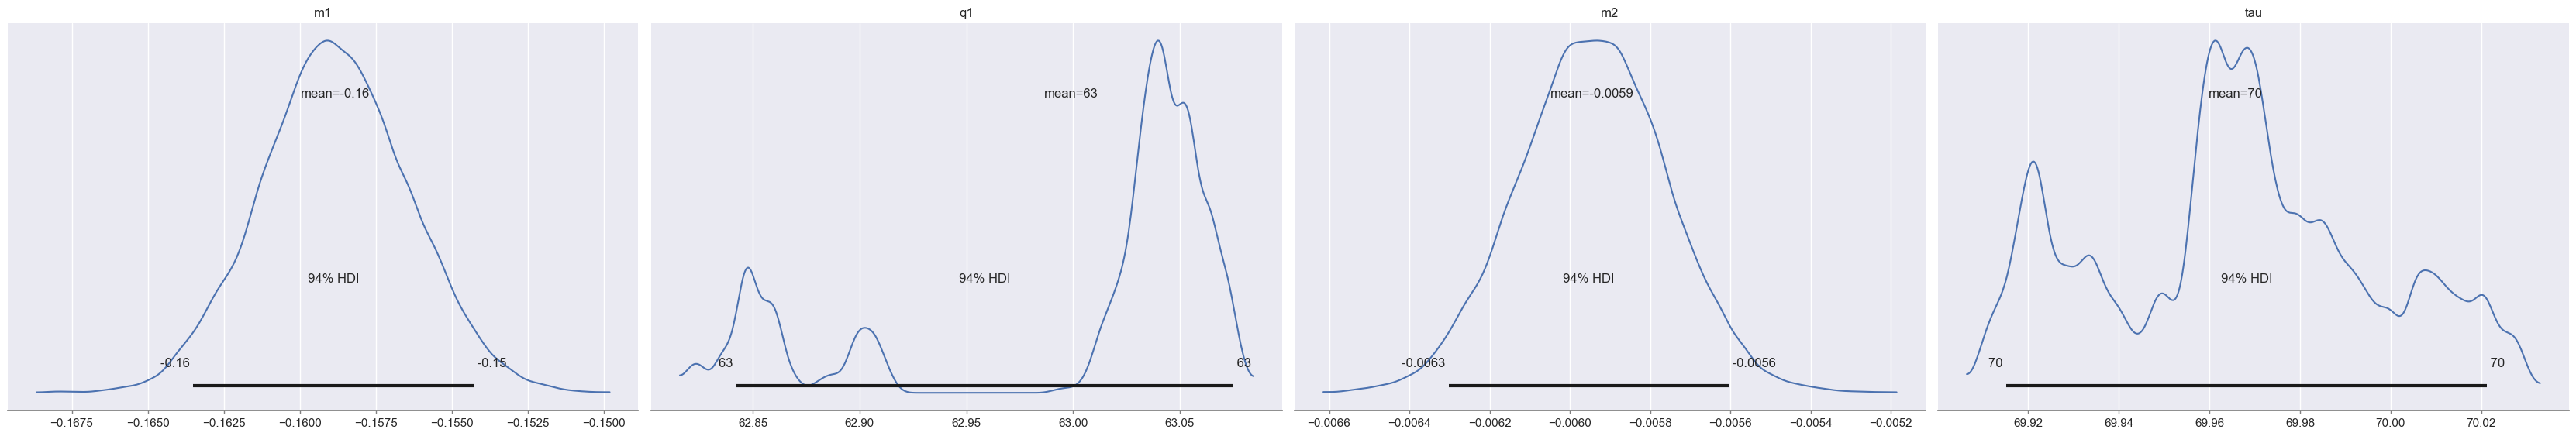

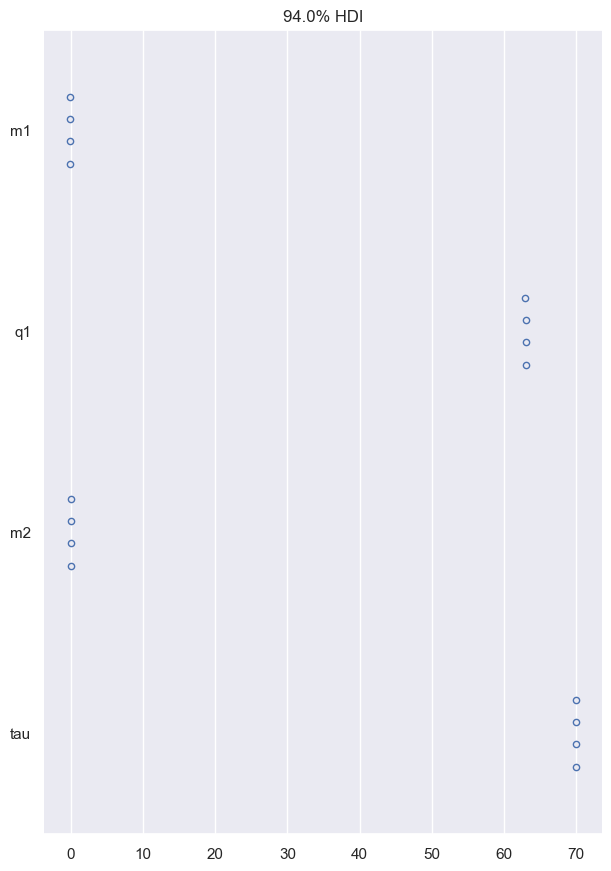

In [44]:
az.plot_trace(inference_data)

az.plot_autocorr(inference_data)

az.plot_posterior(inference_data)

az.plot_forest(inference_data)

In [45]:
def generate_synthetic_dataset_switchpoint(m1, q1, m2, tau, x):
    rv_y = tfd.Normal(
        loc=(
            (m1 * x + q1) * tf.cast(tau > x, tf.float32)
            + (m2 * x + ((m1 - m2) * tau + q1)) * tf.cast(tau <= x, tf.float32)
        ),
        scale=3.
    )
    
    y_mean = rv_y.mean()
    y_samples = rv_y.sample()
    
    return y_mean, y_samples

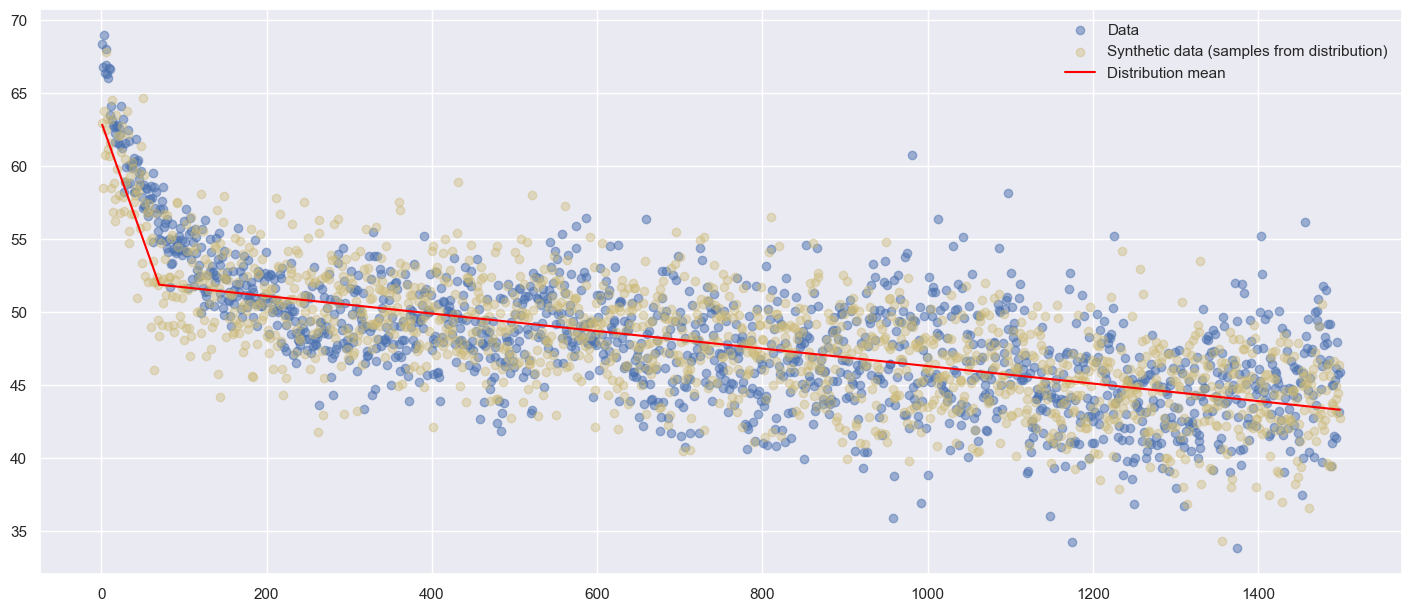

In [46]:
y_mean, y_samples = generate_synthetic_dataset_switchpoint(
    *(az.summary(inference_data)['mean'].tolist() + [x_values])
)

fig = plt.figure(figsize=(14, 6))

sns.set_theme()

plt.scatter(
    x=mean_data['x'],
    y=mean_data['y'],
    alpha=0.5,
    label='Data')

plt.scatter(
    x_values.numpy(),
    y_samples.numpy(),
    alpha=.4,
    color='y',
    label='Synthetic data (samples from distribution)')

plt.plot(
    x_values.numpy(),
    y_mean.numpy(),
    color='red',
    label='Distribution mean')

plt.legend()

Further ideas:
- Model heteroskedasticity (see analysis on $\sigma$ above).
- Update to the new way of imposing the step size adaptation policy.
- Make the switchpoint differentiable: HMC uses gradients and a step-change for the switchpoint makes that point in parameter space (for $m$) not differentiable. Is it possible to impose a "differentiable" switchpoint? See the TFP [switchpoint analysis example](https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis).
- Reparametrize the model to have a single straight line with $x$-dependent $m$ and $q$ parameters, instead of two straight lines with a continuity condition between them (is it actually different from what we're doing now?). The above point on the differentiability of the switchpoint may still apply in this case.
- Try NUTS instead of HMC.